# Sistema de seguridad automático en cámaras de vigilancia de bodegas para renta

## Generar modelo prototipo

### Verificar qué tipo de entorno está activo (con o sin GPU)

In [1]:
!nvidia-smi

Wed Feb 21 14:45:09 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Importar utilidades

In [2]:
from IPython import display
from IPython.display import Image
from random import shuffle
from glob import glob
import os

### Instalar paquete de *ultralytics* y verificar requisitos

In [3]:
!pip install ultralytics
display.clear_output()

In [4]:
from ultralytics import YOLO
!yolo checks

Ultralytics YOLOv8.1.17 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.3/78.2 GB disk)

OS                  Linux-6.1.58+-x86_64-with-glibc2.35
Environment         Colab
Python              3.10.12
Install             pip
RAM                 12.67 GB
CPU                 Intel Xeon 2.00GHz
CUDA                12.1

matplotlib          ✅ 3.7.1>=3.3.0
opencv-python       ✅ 4.8.0.76>=4.6.0
pillow              ✅ 9.4.0>=7.1.2
pyyaml              ✅ 6.0.1>=5.3.1
requests            ✅ 2.31.0>=2.23.0
scipy               ✅ 1.11.4>=1.4.1
torch               ✅ 2.1.0+cu121>=1.8.0
torchvision         ✅ 0.16.0+cu121>=0.9.0
tqdm                ✅ 4.66.2>=4.64.0
psutil              ✅ 5.9.5
py-cpuinfo          ✅ 9.0.0
thop                ✅ 0.1.1-2209072238>=0.1.1
pandas              ✅ 1.5.3>=1.1.4
seaborn             ✅ 0.13.1>=0.11.0


### Instalar Roboflow, descargar datos en formato Yolov8 y ajustar archivos

Video que muestra cómo descargar datos de **Roboflow** y cómo obtener tu clave ya que te hayas creado una cuenta:

https://www.youtube.com/watch?v=76E6esnez8E

In [5]:
!pip install roboflow
display.clear_output()

from roboflow import Roboflow
rf = Roboflow(api_key="tu-clave-aqui")
project = rf.workspace("project-d4kos").project("human-cctv")
dataset = project.version(1).download("yolov8")

img_size = 640

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.1.17, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to human(cctv)-1 in yolov8:: 100%|██████████| 3512/3512 [00:00<00:00, 5879.82it/s]


In [6]:
with open('/content/human(cctv)-1/data.yaml', 'w') as f:
  f.write(
'''names:
- persona
nc: 1
roboflow:
  license: CC BY 4.0
  project: human-cctv
  url: https://universe.roboflow.com/project-d4kos/human-cctv/dataset/1
  version: 1
  workspace: project-d4kos
test: test/images
train: train/images
val: valid/images
'''
)

### Entrenar y validar modelo prototipo

In [7]:
!yolo task=detect mode=train model=yolov8n.pt data="/content/human(cctv)-1/data.yaml" epochs=10 imgsz={img_size}

100% 6.23M/6.23M [00:00<00:00, 236MB/s]
Ultralytics YOLOv8.1.17 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/human(cctv)-1/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=

In [8]:
!yolo task=detect mode=val model=/content/runs/detect/train/weights/best.pt data="/content/human(cctv)-1/data.yaml" imgsz={img_size}

Ultralytics YOLOv8.1.17 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning /content/human(cctv)-1/valid/labels.cache... 119 images, 0 backgrounds, 0 corrupt: 100% 119/119 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 8/8 [00:07<00:00,  1.03it/s]
                   all        119        161      0.887      0.783      0.875      0.376
Speed: 6.5ms preprocess, 10.2ms inference, 0.0ms loss, 23.8ms postprocess per image
Results saved to runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val


### Inferencia / Prueba del modelo en imágenes nuevas

In [9]:
!yolo task=detect mode=predict model=/content/runs/detect/train/weights/best.pt conf=0.5 source="/content/human(cctv)-1/test/images" imgsz={img_size} save_txt=true save_conf=true
display.clear_output()

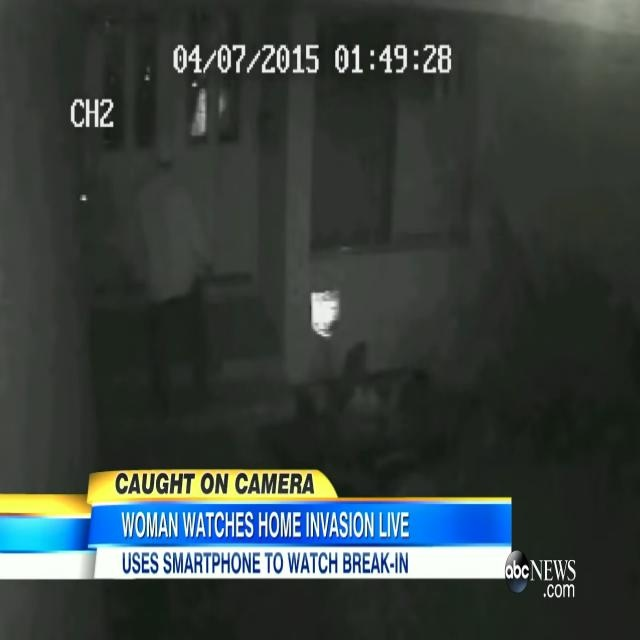

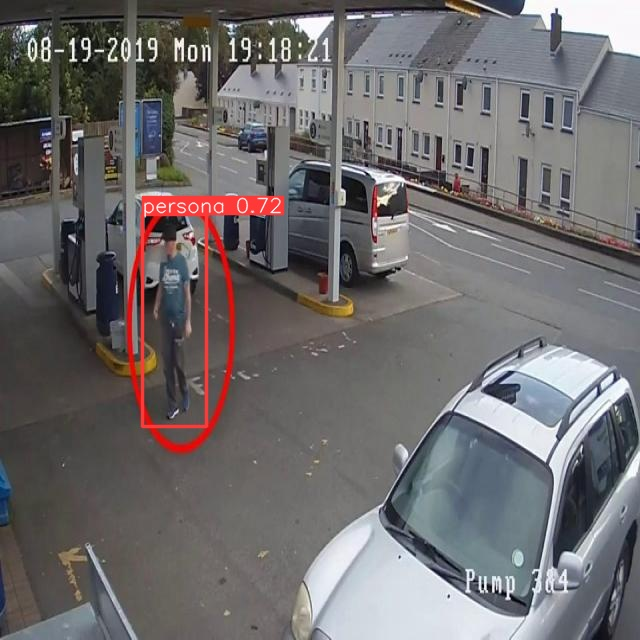

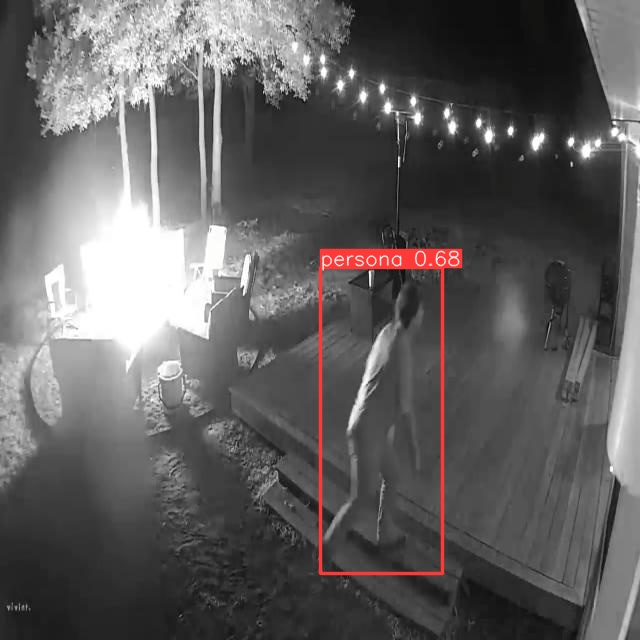

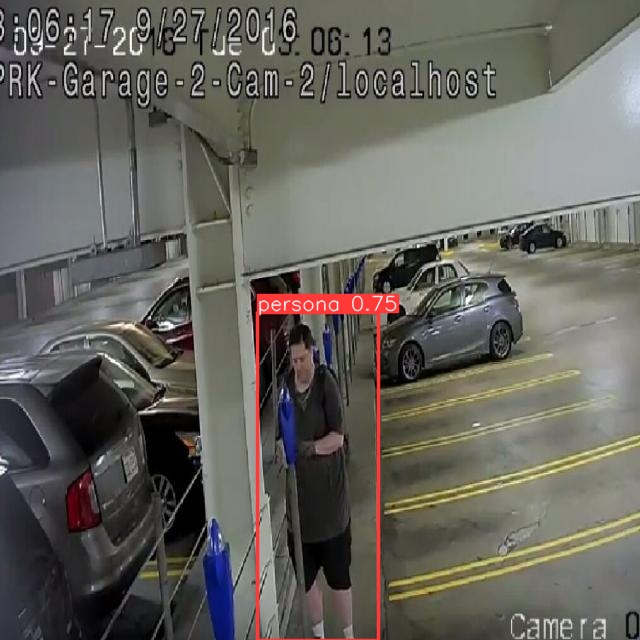

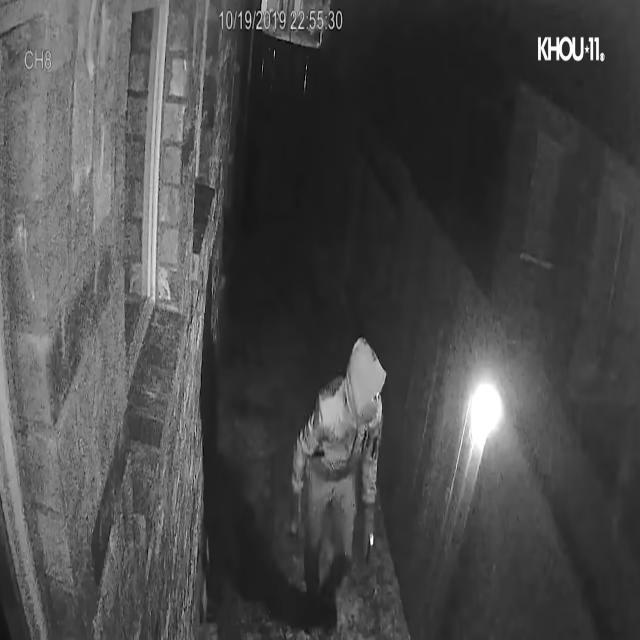

In [10]:
imagenes = glob(f'/content/runs/detect/predict/*.jpg')
shuffle(imagenes)

for i in range(5):
  image_path = imagenes[i]
  display.display(Image(filename=image_path, height=600))
  print("\n")

## Usar modelo en video de cámara de vigilancia

### Instalar y usar *pytube* para obtener video de YouTube

In [11]:
!pip install pytube
display.clear_output()

In [12]:
from pytube import YouTube

link="https://www.youtube.com/watch?v=jsRcNkkGxis"

try:
    yt = YouTube(link)
except:
    print("Error de conexión")

yt.streams.filter(file_extension='mp4')
stream = yt.streams.get_by_itag(22)
stream.download()

title = yt.title.replace('|','')
os.rename(f"/content/{title}.mp4", "/content/video.mp4")

### Inferir / Probar modelo en video

In [13]:
!yolo task=detect mode=predict model=/content/runs/detect/train/weights/best.pt source=/content/video.mp4 imgsz={img_size} save_txt=true save_conf=true
display.clear_output()

### Descargar video con recuadros y modelo de detección

In [16]:
from google.colab import files
files.download('/content/runs/detect/predict2/video.avi')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
files.download('/content/runs/detect/train/weights/best.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>